# Trade with XGBoost algorithm
## Background
In the [portfolio trade example](https://github.com/rapidsai/gQuant/blob/master/notebooks/04_portfolio_trade.ipynb), we use gQuant to backtest a simple mean reversion trading strategy on 5000 stocks.
It shows decent performance by tweaking the moving average window size. Searching for alpha signal is the ultimate goal for the trading companies. A lot of different methods are used to do so. Machine learning approach
is one of those. It has the benefits of extracting important information in the data automatically given enough computation. There are a few popular machine learning algrithoms, including SVM, Random forest tree etc. Amoung those, XGBoost is known to be a very powerful machine 
learning method that is winning a lot of [ML competitions](https://medium.com/syncedreview/tree-boosting-with-xgboost-why-does-xgboost-win-every-machine-learning-competition-ca8034c0b283). Luckily, the [RAPIDS library](https://github.com/rapidsai) accelerates the XGBoost ML algorithm in the GPU so that we can easily take advantage of it in the gQuant. 

In this notebook, we are going to demo how to use gQuant to backtest a XGBoost based trading stragty.


## Environment Preparation

### Download the example Datasets
Before getting started, let's download the example datasets if not presen

In [1]:
! ((test ! -f './data/stock_price_hist.csv.gz' ||  test ! -f './data/security_master.csv.gz') && \
  cd .. && bash download_data.sh) || echo "Dataset is already present. No need to re-download it."

Dataset is already present. No need to re-download it.


### Prepare for running in Dask environment

Let's start the Dask local cluster environment for distributed computation.

Dask provides a web-based dashboard to help to track progress, identify performance issues, and debug failures. To learn more about Dask dashboard, just follow this [link](https://distributed.dask.org/en/latest/web.html).


In [2]:
# Start the Dask local cluster environment for distrubuted computation
from dask_cuda import LocalCUDACluster
from dask.distributed import Client

cluster = LocalCUDACluster()
client = Client(cluster)
client


Client Scheduler: tcp://127.0.0.1:45867 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 2 Memory: 100.00 GB


Though our stock dataset is small enough to fit in a single 16G GPU, to show how to do distributed computation, we will split the dataframe into small pieces to be loaded by different workers in the cluster.

Notice this step is need only if the dataset is not split in multiple files yet.

First use this simple taskgraph to load data then sort it by the asset id and datatime:

In [3]:
import sys; sys.path.insert(0, '..')
import warnings
from gquant.dataframe_flow import TaskGraph
import ipywidgets as widgets
import os
warnings.simplefilter("ignore")
task_graph = TaskGraph.load_taskgraph('../taskgraphs/sort_stocks.gq.yaml')
input_cached, = task_graph.run()
task_graph.draw()

GQuantWidget(sub=HBox(), value=[OrderedDict([('id', 'stock_data'), ('type', 'CsvStockLoader'), ('conf', {'file…

convert the sorted stock data into partitions and save it into csv files. Note, the data is slited in a way that the same asset belongs to the same partition

In [ ]:
import dask.dataframe as dd
import os
num_partitions = 8

os.makedirs('many-small', exist_ok=True)
dd.from_pandas(input_cached.set_index('asset'), npartitions=num_partitions).reset_index().to_csv('many-small/*.csv', index=False)

Note, this notebook requires `cudf` of version >=0.8.0. It can be checked by following command

In [4]:
import cudf
print(cudf.__version__)

0.14.0


## The toy example
To mimic the end-to-end quantitative analyst task, we are going to backtest a XGBoost trading strategy. 

We will reuse the preprocessing steps as shown in the portfolio trade notebook example. 

The workflow includes following steps:

1. Preprocess the datasets.

4. Compute the features based on different technical indicators 

5. Split the data in training and testing and build a XGBoost model based on the training data. From the XGBoost model, compute the trading signals for all the data points.

5. Run backtesting and compute the returns from this strategy for each of the days and stock symbols 

6. Run a simple portfolio optimization by averaging the stocks together for each of the trading days.

7. Compute the sharpe ratio and cumulative return results for both training and testing datasets

The whole workflow can be organized into a TaskGraph, which are fully described in a `.gq.yaml` file.

Each nodes has a unique id, a node type, configuration parameters and input nodes ids. gQuant takes this yaml file, wires it into a graph to visualize it.

First let's load the proprocess TaskGraph:

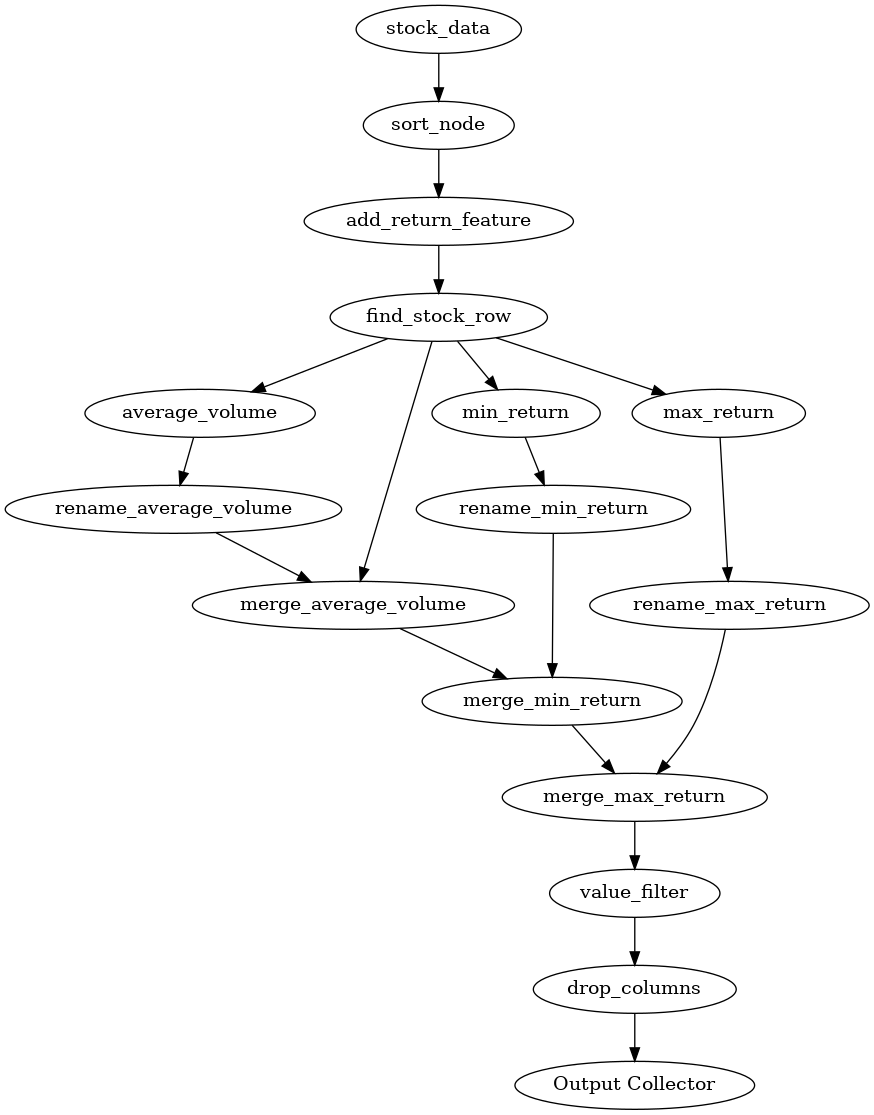

In [5]:
task_graph = TaskGraph.load_taskgraph('../taskgraphs/preprocess.gq.yaml')
task_graph.draw(show='ipynb')

It can be shown in the interactive gQuant widget. Try to run it and see the preprocess results:

In [6]:
task_graph.draw()

GQuantWidget(sub=HBox(), value=[OrderedDict([('id', 'stock_data'), ('type', 'CsvStockLoader'), ('conf', {'file…

Lode the whole TaskGraph by `load_taskgraph` command. Note the preprocess TaskGraph is included inside the `preprocess` `Composite Node`.

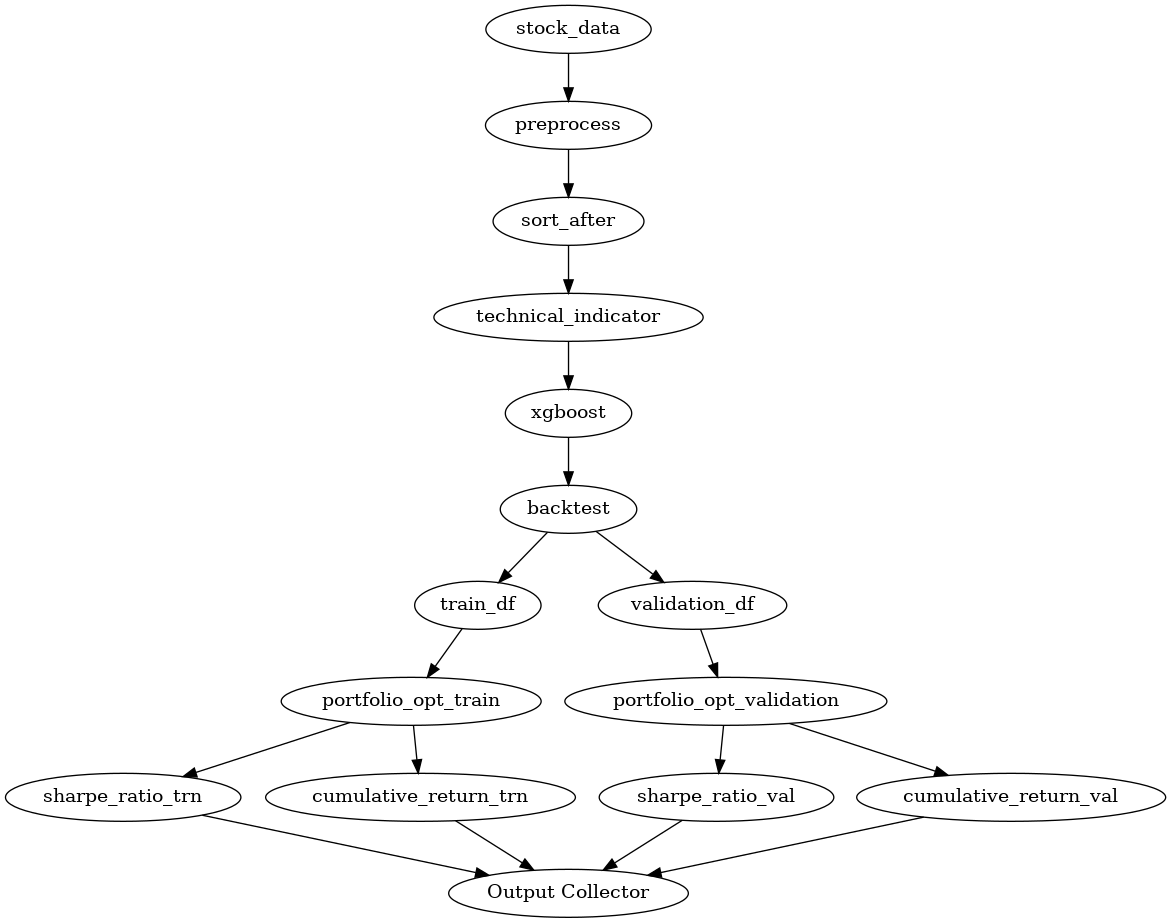

In [7]:
task_graph = TaskGraph.load_taskgraph('../taskgraphs/xgboost_trade.gq.yaml')
task_graph.draw(show='ipynb')

To see the input/output ports of the nodes, turn show_ports flag on

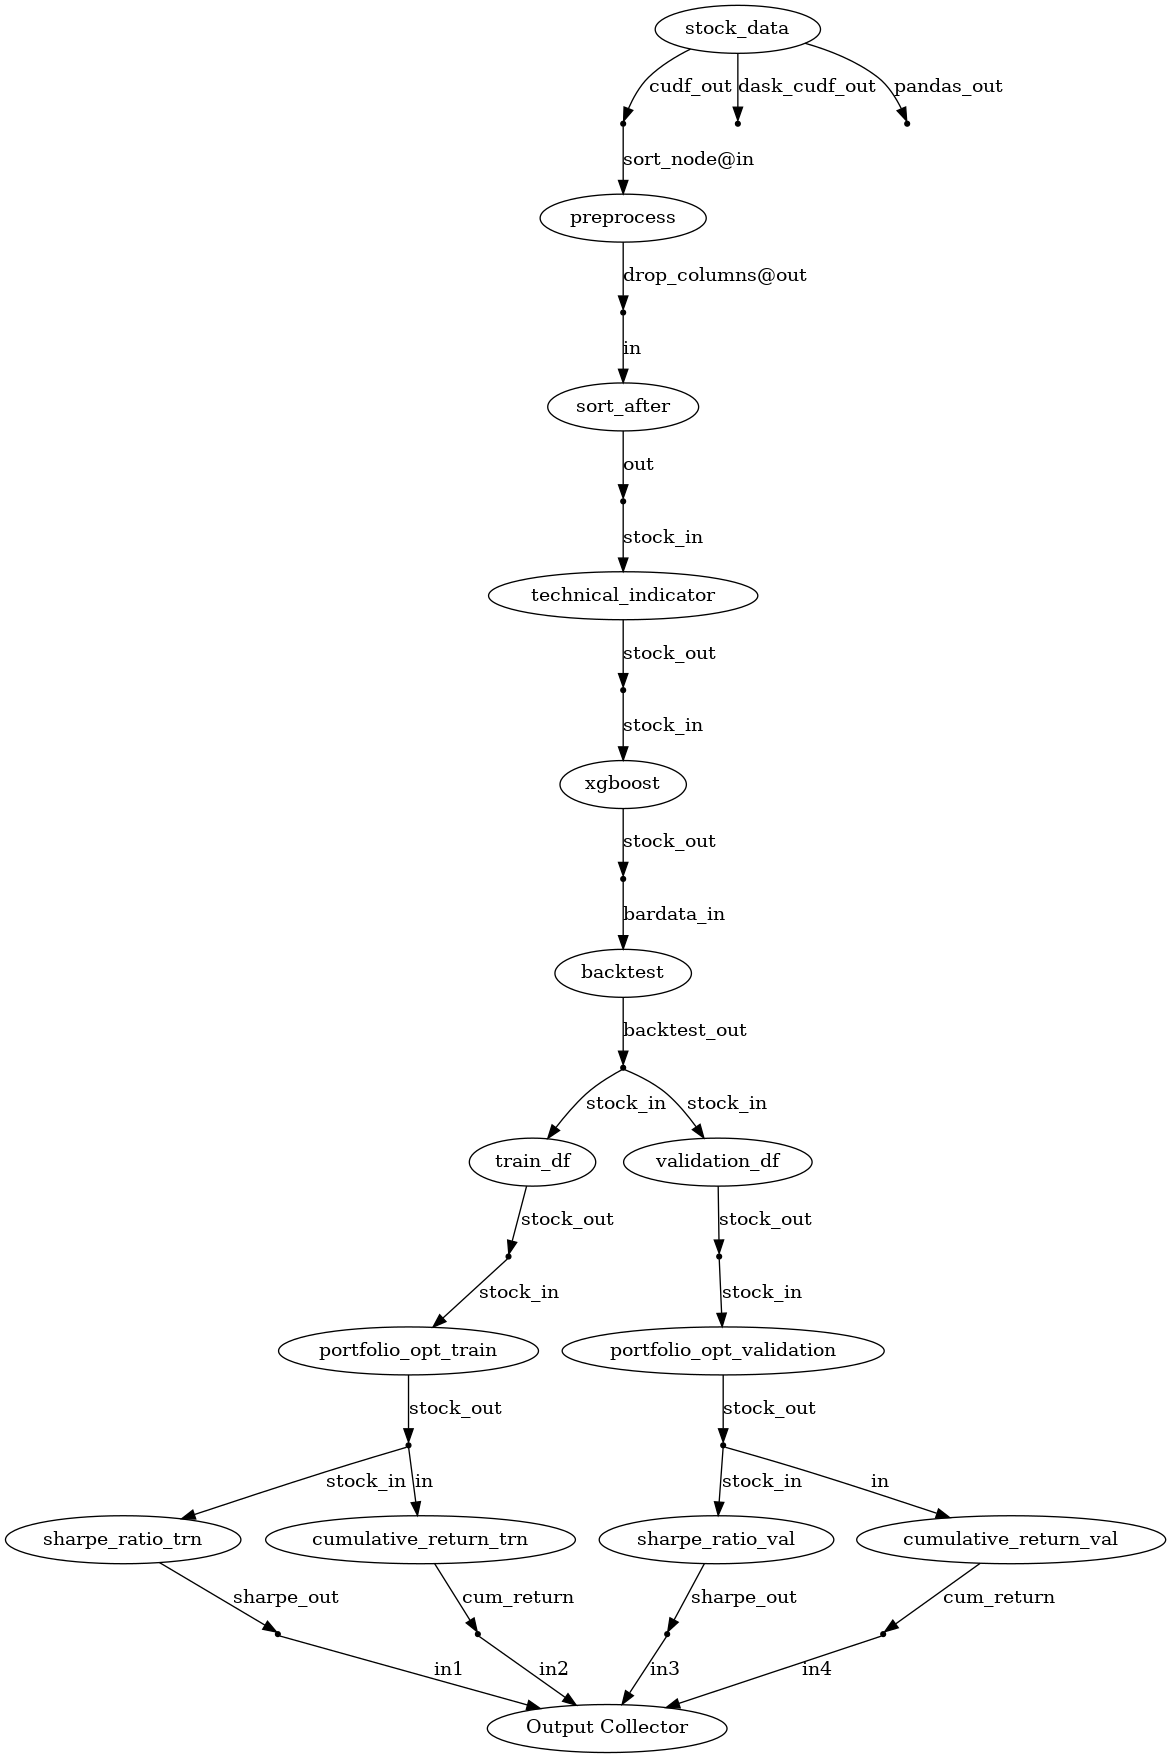

In [8]:
task_graph.draw(show='ipynb', show_ports=True)

Similarly, it can be shown in the interactive gQuant widget. Try to run it, change the parameters and play with it

In [9]:
task_graph.draw()

GQuantWidget(sub=HBox(), value=[OrderedDict([('id', 'stock_data'), ('type', 'CsvStockLoader'), ('conf', {'file…

The features used for XGBoost algorithm are prepared in the `xgboost` Task node, where `cuIndicator` module is used to compute the technical indicators in the GPU for all the stock symbols. `xgboost` is the Task node that is used to compute the trading signals from the stock technical indicators. Each of the gQuant Task node is implemented by overwriting `columns_setup`, `process`, `ports_setup`, `conf_chema` methods of the Node base class. Please refer to [customize nodes notebook](https://github.com/rapidsai/gQuant/blob/master/notebooks/05_customize_nodes.ipynb) for details. Following is the source code for "XGBoostStrategyNode":

In [10]:
import inspect
from gquant.plugin_nodes import XGBoostStrategyNode

print(inspect.getsource(XGBoostStrategyNode))

class XGBoostStrategyNode(Node):
    """
    This is the Node used to compute trading signal from XGBoost Strategy.
    It requires the following conf fields:
        "train_date": a date string of "Y-m-d" format. All the data points
        before this date is considered as training, otherwise as testing. If
        not provided, all the data points are considered as training.
        "xgboost_parameters": a dictionary of any legal parameters for XGBoost
        models. It overwrites the default parameters used in the process method
        "no_feature": specifying a list of columns in the input dataframe that
        should NOT be considered as training features.
        "target": the column that is considered as "target" in machine learning
        algorithm
    It requires the "datetime" column for spliting the data points and adds a
    new column "signal" to be used for backtesting.
    The detailed computation steps are listed in the process method's docstring
    """

    def i

### XGBoost Trading Strategy Performance
Similar to tensorflow, gQuant graph is evaluated by specifying the output nodes and input nodes replacement. We first look at the column result from data preparation node.

In [11]:
from pprint import pprint
print('Output columns of node node_technical_indicator:')
task_graph.build()
pprint(task_graph['technical_indicator'].columns_setup())

Output columns of node node_technical_indicator:
{'stock_out': {'BO_BA_b1_10': 'float64',
               'BO_BA_b2_10': 'float64',
               'CH_OS_10_20': 'float64',
               'SHIFT_-1': 'float64',
               'asset': 'int64',
               'close': 'float64',
               'datetime': 'date',
               'high': 'float64',
               'indicator': 'int32',
               'low': 'float64',
               'open': 'float64',
               'returns': 'float64',
               'volume': 'float64'}}


It adds the columns "BO_BA_b1_10", "BO_BA_b2_10", 'CH_OS_10_20" as features and "SHFIT_-1" as the target, which is the return of next day. A good feature should be the one that provides highest information about the next day return. In the case we have no prior information about it,
we can compute as many features as we like and leave it to the XGBoost to find the right combination of those features. 

Evaluate the leaf nodes of the backtesting graph by gQuant `run` method.

In [12]:
%%time
output_list = ['sharpe_ratio_trn.sharpe_out',
               'cumulative_return_trn.cum_return',
               'sharpe_ratio_val.sharpe_out',
               'cumulative_return_val.cum_return',
               'sort_after.out']
o_gpu = task_graph.run(output_list, profile=True)
cached_sort = o_gpu['sort_after.out']

id:stock_data process time:4.153s
id:preprocess process time:0.546s
id:sort_after process time:0.051s
id:technical_indicator process time:0.116s
id:xgboost process time:2.213s
id:backtest process time:0.002s
id:train_df process time:0.006s
id:portfolio_opt_train process time:0.024s
id:sharpe_ratio_trn process time:0.001s
id:cumulative_return_trn process time:0.023s
id:validation_df process time:0.007s
id:portfolio_opt_validation process time:0.018s
id:sharpe_ratio_val process time:0.001s
id:cumulative_return_val process time:0.021s
CPU times: user 6.8 s, sys: 1.07 s, total: 7.87 s
Wall time: 7.57 s


Define a function to organized the plot results. 

In [13]:
# define the function to format the plots
def plot_figures(o):
    # format the figures
    figure_width = '1200px'
    figure_height = '400px'
    sharpe_number = o['sharpe_ratio_trn.sharpe_out']
    cum_return_train = o['cumulative_return_trn.cum_return']
    cum_return_train.layout.height = figure_height
    cum_return_train.layout.width = figure_width
    cum_return_train.title = 'Training P & L %.3f' % (sharpe_number)
    sharpe_number = o['sharpe_ratio_val.sharpe_out']
    cum_return_test = o['cumulative_return_val.cum_return']
    cum_return_test.layout.height = figure_height
    cum_return_test.layout.width = figure_width
    cum_return_test.title = 'Testing P & L %.3f' % (sharpe_number)

    return widgets.VBox([cum_return_train, cum_return_test])
plot_figures(o_gpu)

The XGBoost model does a good job to predict the next day of return. It overfits in the training dataset and gets Sharpe Ratio of 5 as shown in the figure above. In the testing period, it gets Sharpe Ratio of 1.

The example model runs in a single GPU because of the small dataset. But in real world, the dataset usually is so large that it doesn't fit in a single GPU. Luckily, the XGBoost library natively supports multiple nodes and multiple GPU training by using Dask. You can scale out the computation using Dask dataframe.

To show how easy it is to do distributed computation, let's run the above exmaple in the Dask environment for educational purpose.  


To run the whole workflow, simply change the `preprocess` node to get Dask Dataframe and run the graph again. Here we look at the testing results:

In [14]:
%%time

replace_spec = {'preprocess': {"inputs": {"sort_node@in": "stock_data.dask_cudf_out"}}}
o_gpu = task_graph.run(replace=replace_spec, profile=True)

id:stock_data process time:0.012s
id:preprocess process time:6.982s
id:xgboost process time:2.828s
id:backtest process time:0.016s
id:train_df process time:0.009s
id:portfolio_opt_train process time:0.040s
id:sharpe_ratio_trn process time:1.380s
id:cumulative_return_trn process time:1.375s
id:validation_df process time:0.006s
id:portfolio_opt_validation process time:0.039s
id:sharpe_ratio_val process time:1.383s
id:cumulative_return_val process time:1.478s
CPU times: user 9.29 s, sys: 666 ms, total: 9.96 s
Wall time: 24.4 s


In [15]:
plot_figures(o_gpu)


Clearly, 3 feautres is way too little here. gQuant implmented 36 technical indicators. We can change the configuration of node_technical_indicator node to include more features.

In [16]:
chaikin_para0 = 10
chaikin_para1 = 20
bollinger_para = 10
macd_para0 = 2
macd_para1 = 3
rsi_para0 = 5
atr_para0 = 10
sod_para = 2
mflow_para = 3
findex_para = 5
adis_para = 5
ccindex_para = 5
bvol_para = 3
vindex_para = 3
mindex_para0 = 10
mindex_para1 = 15
tindex_para0 = 5
tindex_para1 = 10
emove_para = 5
cc_para = 15
kchannel_para = 10
indicator_conf = {
    "indicators": [
        {"function": "port_chaikin_oscillator",
         "columns": ["high", "low", "close", "volume"],
         "args": [chaikin_para0, chaikin_para1]
        },
        {"function": "port_bollinger_bands",
         "columns": ["close"],
         "args": [bollinger_para],
         "outputs": ["b1", "b2"]
        },
        {"function": "port_macd",
         "columns": ["close"],
         "args": [macd_para0, macd_para1],
         "outputs": ["MACDsign", "MACDdiff"]
        },
        {"function": "port_relative_strength_index",
         "columns": ["high", "low"],
         "args": [rsi_para0],
        },
        {"function": "port_average_true_range",
         "columns": ["high", "low", "close"],
         "args": [atr_para0],
        },
        {"function": "port_stochastic_oscillator_k",
         "columns": ["high", "low", "close"],
         "args": [],
        },
        {"function": "port_stochastic_oscillator_d",
         "columns": ["high", "low", "close"],
         "args": [sod_para],
        },
        {"function": "port_money_flow_index",
         "columns": ["high", "low", "close", "volume"],
         "args": [mflow_para],
        },
        {"function": "port_force_index",
         "columns": ["close", "volume"],
         "args": [findex_para],
        },
        {"function": "port_ultimate_oscillator",
         "columns": ["high","low","close"],
         "args": [],
        },
        {"function": "port_accumulation_distribution",
         "columns": ["high","low","close","volume"],
         "args": [adis_para],
        },
        {"function": "port_commodity_channel_index",
         "columns": ["high","low","close"],
         "args": [ccindex_para],
        },
        {"function": "port_on_balance_volume",
         "columns": ["close", "volume"],
         "args": [bvol_para],
        },
        {"function": "port_vortex_indicator",
         "columns": ["high", "low", "close"],
         "args": [vindex_para],
        },
         {"function": "port_kst_oscillator",
         "columns": ["close"],
         "args": [3, 4, 5, 6, 7, 8, 9, 10],
        },
        {"function": "port_mass_index",
         "columns": ["high", "low"],
         "args": [mindex_para0, mindex_para1],
        },
        {"function": "port_true_strength_index",
         "columns": ["close"],
         "args": [tindex_para0, tindex_para1],
        },
        {"function": "port_ease_of_movement",
         "columns": ["high", "low", "volume"],
         "args": [emove_para],
        },
        {"function": "port_coppock_curve",
         "columns": ["close"],
         "args": [cc_para],
        },
        {"function": "port_keltner_channel",
         "columns": ["high", "low", "close"],
         "args": [kchannel_para],
         "outputs": ["KelChD", "KelChM", "KelChU"]
        },
        {"function": "port_ppsr",
         "columns": ["high", "low", "close"],
         "args": [],
         "outputs": ["PP", "R1", "S1", "R2", "S2", "R3", "S3"]
        },
        {"function": "port_shift",
         "columns": ["returns"],
         "args": [-1]
        }        
    ],
    "remove_na": True
}

In [17]:
task_graph.draw()

GQuantWidget(cache={'height': 600.6, 'width': 2002, 'nodes': [{'width': 140, 'id': 'stock_data', 'type': 'CsvS…

Run the backtesting again

In [18]:
%%time
replace_spec = {}
replace_spec['technical_indicator'] = {"conf": indicator_conf}

replace_spec['sort_after'] = {"load": {'out': cached_sort}}

o_gpu = task_graph.run(replace=replace_spec, profile=True)


id:technical_indicator process time:5.121s
id:xgboost process time:5.275s
id:backtest process time:0.006s
id:train_df process time:0.007s
id:portfolio_opt_train process time:0.024s
id:sharpe_ratio_trn process time:0.001s
id:cumulative_return_trn process time:0.021s
id:validation_df process time:0.006s
id:portfolio_opt_validation process time:0.018s
id:sharpe_ratio_val process time:0.001s
id:cumulative_return_val process time:0.022s
CPU times: user 9.96 s, sys: 1.34 s, total: 11.3 s
Wall time: 10.9 s


In [19]:
plot_figures(o_gpu)

We get Sharpe Ratio of `1.93` in the testing dataset, not bad!

Using `min_volume=400.0`, it selects 1558 stocks. Setting a lower threshhold, it can include more stocks for the backtesting and hence increase the Sharpe Ratio. But it runs out of memory of single GPU. We have shown Dask can help to break down the large task into small tasks and schedule them a distributed environment. So we can handle dataset of any sizes in this way:

In [20]:
%%time
min_volume = 4.0
min_rate = -10.0
max_rate = 10.0
replace_spec={}
replace_spec['technical_indicator'] = {"conf": indicator_conf}

replace_spec['node_filterValue']={"conf": [{"column": "volume_mean", "min": min_volume},
                                            {"column": "returns_max", "max": max_rate},
                                            {"column": "returns_min", "min": min_rate}]}
replace_spec['preprocess'] = {"conf": {"subnodes_conf": {
                                            "value_filter": {
                                                "conf": [{"column": "average_volume", "min": min_volume},
                                                         {"column": "max_return", "max": max_rate},
                                                         {"column": "min_return", "min": min_rate}]
                                            },
                                            "drop_columns": {
                                                "conf": {
                                                    "columns": ["average_volume", "min_return", "max_return"]
                                                }
                                            }
                                        },
                                        "taskgraph": "taskgraphs/preprocess.gq.yaml",
                                        "input": ["sort_node.in"],
                                        "output": ["drop_columns.out"]
                                    },
                              "inputs": {"sort_node@in": "stock_data.dask_cudf_out"}}

o_gpu = task_graph.run(replace=replace_spec, profile=True)
plot_figures(o_gpu)

id:stock_data process time:0.116s
id:preprocess process time:7.146s
id:xgboost process time:8.109s
id:backtest process time:0.017s
id:train_df process time:0.007s
id:portfolio_opt_train process time:0.056s
id:sharpe_ratio_trn process time:2.153s
id:cumulative_return_trn process time:2.232s
id:validation_df process time:0.007s
id:portfolio_opt_validation process time:0.045s
id:sharpe_ratio_val process time:2.337s
id:cumulative_return_val process time:2.479s
CPU times: user 11.7 s, sys: 1.8 s, total: 13.5 s
Wall time: 46.2 s


In [21]:
plot_figures(o_gpu)

We get Sharpe Ratio of `4.7` in the testing dataset. This is a great improvement!

## Strategy parameter search
Quantitative analyst usually need to explore different parameters for their trading strategy. The exploration process is an iterative process. gQuant help to speed up this by allowing using cached dataframe and evaluating the sub-graphs.

To find the optimal technical indicator parameters for this XGBoost strategy, we build a wiget to search the parameter interactively. 

In [22]:
import plotutils
replace_spec={}
replace_spec['technical_indicator'] = {"conf": indicator_conf}
replace_spec['sort_after'] = {"load": {'out': cached_sort}}
plotutils.getXGBoostWidget(replace_spec, task_graph, plot_figures)

### Conclusions
In this notebook, we demoed how to use gQuant to backtest XGBoost trading strategy. It is convenient and efficient to use indicator node from the gQuant to compute features for all the stocks in the dataset in the GPU. The XGBoost training are computed in the GPU, so we can get the results quickly. This example shows the XGBoost algorithm's power in finding trading signals. We can achieve close to 2 raw Sharpe ratio in the testing time period.